In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import cv2
import os
import scipy.signal as sigl 
import scipy.ndimage as ndi
import scipy.fft as fft
from PIL import Image

In [2]:
p1=4
p2=4.2
p_a=2*p1*p2/(p1+p2)
M=2*p_a/(p2-p1)
pix=7.8125
lens=10
print(' M= '+str('%.3f'%M))


 M= 40.976


In [3]:
thre=6
row1=100
row2=300
def spilt(moire,j):
    moire_resize=moire[20:,20:420]
    m_r1=moire_resize[row1].astype(float)
    m_r2=moire_resize[row2].astype(float)
    if 1.7<j<2.3:
        for k in (m_r1,m_r2):
            m_r1_valley=abs(m_r1-255)
            m_r2_valley=abs(m_r2-255)
        m_r1=m_r1_valley
        m_r2=m_r2_valley

    pic_len=m_r2.size//2
    y_a1=m_r1[:pic_len]-m_r1[:pic_len].mean()
    y_a2=m_r1[pic_len:]-m_r1[pic_len:].mean()
    y_b1=m_r2[:pic_len]-m_r2[:pic_len].mean()
    y_b2=m_r2[pic_len:]-m_r2[pic_len:].mean()
    return(y_a1,y_a2,y_b1,y_b2)

def wave_ifft(y_a,y_b):
    #wave 1
    wave1_fft=fft.fft(y_a)
    wave1_fft_2 = wave1_fft.copy()
    wave1_fft_2[thre:-thre]=0
    wave1_ifft = fft.ifft(wave1_fft_2)
    #wave2
    wave2_fft=fft.fft(y_b)
    wave2_fft_2 = wave2_fft.copy()
    wave2_fft_2[thre:-thre]=0
    wave2_ifft = fft.ifft(wave2_fft_2)
    return(wave_peak1(wave1_ifft,wave2_ifft))

    
def wave_peak1(w_p1,w_p2):
    wave1_peak=sigl.find_peaks(w_p1,height=12,distance=50)[0]
    wave2_peak=sigl.find_peaks(w_p2,height=12,distance=50)[0]
     
    pic_len=w_p1.size
#     wave2_peak=wave2_peak+pic_len
#     print(wave1_peak,wave2_peak)
    peak_con=np.concatenate((wave1_peak,wave2_peak))
#     print("peak_con="+str(peak_con))
    return(peak_con)

def Cal_result(origin_D_X,j):
    Delta_X=origin_D_X.tolist()
#     print(Delta_X)
    Delta_X.remove(min(Delta_X))
    Delta_X.remove(min(Delta_X))
    
    Delta_X=np.sum(Delta_X)/len(Delta_X)
#     print(Delta_X)
    delta_x=Delta_X*pix/M/lens
    error=delta_x-j
    error_ab=abs(error)
    return(delta_x,Delta_X,error,error_ab)



In [12]:
x_scale=[]
delta_xs=[]
DX_simu_s=[]
error_s=[]
error_ab_s=[]

for j in np.arange(0.1,1.5,0.1):
#     if np.fabs(j-1.7) < 1e-3:
#         continue
    #read &spilt 
    moire=cv2.imread('/Users/chunglee_people/Desktop/python-jupyter/%.1f_c.png'%(j),0) 
    sp_m=spilt(moire,j)
    #calculate
    Delta_X=abs(wave_ifft(sp_m[0],sp_m[1])-wave_ifft(sp_m[2],sp_m[3]))
    #results
    dx_simu=Cal_result(Delta_X,j)[0]
    DX_simu=Cal_result(Delta_X,j)[1]
    error=Cal_result(Delta_X,j)[2]
    error_ab=Cal_result(Delta_X,j)[3]
    
    #append
    x_scale.append(j)
    DX_simu_s.append(DX_simu)
    delta_xs.append(dx_simu)
    error_s.append(error)
    error_ab_s.append(error_ab)
    
    
    
    print("when x= "+str('%.2f'%j)+', dx_simu= '+str('%.4f'%dx_simu)+', DX_simu='+str('%.2f'%DX_simu)\
          +', error='+str('%.2f'%error)+', error_ab='+str('%.2f'%error_ab))
    

    
    
 

when x= 0.10, dx_simu= 0.1335, DX_simu=7.00, error=0.03, error_ab=0.03
when x= 0.20, dx_simu= 0.2002, DX_simu=10.50, error=0.00, error_ab=0.00
when x= 0.30, dx_simu= 0.3432, DX_simu=18.00, error=0.04, error_ab=0.04
when x= 0.40, dx_simu= 0.4576, DX_simu=24.00, error=0.06, error_ab=0.06
when x= 0.50, dx_simu= 0.4862, DX_simu=25.50, error=-0.01, error_ab=0.01
when x= 0.60, dx_simu= 0.6197, DX_simu=32.50, error=0.02, error_ab=0.02
when x= 0.70, dx_simu= 0.7340, DX_simu=38.50, error=0.03, error_ab=0.03
when x= 0.80, dx_simu= 0.7436, DX_simu=39.00, error=-0.06, error_ab=0.06
when x= 0.90, dx_simu= 0.9342, DX_simu=49.00, error=0.03, error_ab=0.03
when x= 1.00, dx_simu= 0.9628, DX_simu=50.50, error=-0.04, error_ab=0.04
when x= 1.10, dx_simu= 1.0296, DX_simu=54.00, error=-0.07, error_ab=0.07
when x= 1.20, dx_simu= 1.1630, DX_simu=61.00, error=-0.04, error_ab=0.04
when x= 1.30, dx_simu= 1.0868, DX_simu=57.00, error=-0.21, error_ab=0.21
when x= 1.40, dx_simu= 1.3060, DX_simu=68.50, error=-0.09, 

In [13]:
offset=np.arange(0.1,2.2,0.1)
print(offset)
re_Dx=np.array([7.0, 10.5, 18.0, 24.0, 25.5, 32.5, 38.5, 39.0\
       , 49.0, 50.5,\
                54.0, 61.0, 60.0, 68.5, 74.0, 80.5, 86.5, 91 ,95.5, 100,104])
re_dx=re_Dx*pix/M/lens
error=re_dx-offset
Abs_error=abs(error)
error_percent=100*(Abs_error/offset)

print(re_dx)
print(error)
print(Abs_error)
print(error_percent)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1]
[0.13346354 0.20019531 0.34319196 0.45758929 0.48618862 0.61965216
 0.73404948 0.74358259 0.93424479 0.96284412 1.02957589 1.16303943
 1.14397321 1.30603609 1.4109003  1.53483073 1.64922805 1.73502604
 1.82082403 1.90662202 1.9828869 ]
[ 0.03346354  0.00019531  0.04319196  0.05758929 -0.01381138  0.01965216
  0.03404948 -0.05641741  0.03424479 -0.03715588 -0.07042411 -0.03696057
 -0.15602679 -0.09396391 -0.0890997  -0.06516927 -0.05077195 -0.06497396
 -0.07917597 -0.09337798 -0.1171131 ]
[0.03346354 0.00019531 0.04319196 0.05758929 0.01381138 0.01965216
 0.03404948 0.05641741 0.03424479 0.03715588 0.07042411 0.03696057
 0.15602679 0.09396391 0.0890997  0.06516927 0.05077195 0.06497396
 0.07917597 0.09337798 0.1171131 ]
[33.46354167  0.09765625 14.39732143 14.39732143  2.76227679  3.27535962
  4.86421131  7.05217634  3.80497685  3.7155878   6.40219156  3.08004712
 12.00206044  6.71170812  5.93998016  

In [ ]:
# plt.figure(figsize=(16,9))
# plt.xlabel("$x$  real (µm)",fontsize=16)
# plt.gca().set_aspect('equal')
# plt.ylabel("x_estimated (µm)",fontsize=16)
# plt.xlim(-0.1,xmax)
# plt.ylim(-0.1,xmax)
# plt.plot(offset,re_dx,'ro-')
# plt.plot([-10,10],[-10,10],'--',color='#660022',alpha=0.8)

# plt.figure(figsize=(16,9))
# plt.ylim(-0.3,0.3)
# plt.xlim(0,xmax)
# plt.fill_between([-10,10],[0.1,0.1],[-0.1,-0.1],color='#222288',alpha=0.2)
# plt.plot([-10,10],[0,0],'--',color='#7733AA',alpha=0.8)
# plt.xlabel("$x$ real (µm)",fontsize=16)
# plt.ylabel("error (µm)",fontsize=16)
# plt.plot(offset,error,'go-')

# plt.figure(figsize=(16,9))
# plt.ylim(-0.3,0.3)
# plt.xlim(-0.1,xmax)
# plt.fill_between([-10,10],[0.1,0.1],[-0.1,-0.1],color='#222288',alpha=0.2)
# plt.plot([-10,10],[0,0],'--',color='#7733AA',alpha=0.8)
# plt.xlabel("$x$ real (µm)",fontsize=16)
# plt.ylabel("|error| (µm)",fontsize=16)
# plt.plot(offset,Abs_error,'bo-')

In [15]:
SQ_offset=np.arange(0.1,2.1,0.1)
SQ_simulate=np.array([0.1138,0.148,0.3188,0.444,0.535,\
                     0.5807,0.7517,0.8312,0.8995,0.967,\
                     1.093,1.184,1.298,1.389,1.446,\
                      1.537,1.73,1.81,1.856,2.026])

In [ ]:
# plt.figure(figsize=(16,9))

# plt.xlabel("$x$  real (µm)",fontsize=16)
# plt.gca().set_aspect('equal')
# plt.ylabel("x_estimated (µm)",fontsize=16)
# plt.xlim(-0.1,xmax)
# plt.ylim(-0.1,xmax)
# plt.plot(SQ_offset,SQ_simulate,'ro-')
# plt.plot([-10,10],[-10,10],'--',color='#660022',alpha=0.8)

# plt.figure(figsize=(16,9))
# plt.ylim(-0.3,0.3)
# plt.xlim(0,xmax)
# plt.fill_between([-10,10],[0.1,0.1],[-0.1,-0.1],color='#222288',alpha=0.2)
# plt.plot([-10,10],[0,0],'--',color='#7733AA',alpha=0.8)
# plt.xlabel("$x$ real (µm)",fontsize=16)
# plt.ylabel("error (µm)",fontsize=16)
# plt.plot(SQ_offset,SQ_error,'go-')

# plt.figure(figsize=(16,9))
# plt.ylim(-0.3,0.3)
# plt.xlim(-0.1,xmax)
# plt.fill_between([-10,10],[0.1,0.1],[-0.1,-0.1],color='#222288',alpha=0.2)
# plt.plot([-10,10],[0,0],'--',color='#7733AA',alpha=0.8)
# plt.xlabel("$x$ real (µm)",fontsize=16)
# plt.ylabel("|error| (µm)",fontsize=16)
# plt.plot(SQ_offset,SQ_error_abs,'bo-')


In [17]:
SQ_error=SQ_simulate-SQ_offset

SQ_error_abs=abs(SQ_error)
 
print(SQ_error)
print(SQ_error_abs)
print(np.sum(SQ_error_abs))
print(np.sum(SQ_error_abs)/len(SQ_error_abs))


[ 0.0138 -0.052   0.0188  0.044   0.035  -0.0193  0.0517  0.0312 -0.0005
 -0.033  -0.007  -0.016  -0.002  -0.011  -0.054  -0.063   0.03    0.01
 -0.044   0.026 ]
[0.0138 0.052  0.0188 0.044  0.035  0.0193 0.0517 0.0312 0.0005 0.033
 0.007  0.016  0.002  0.011  0.054  0.063  0.03   0.01   0.044  0.026 ]
0.5623000000000006
0.02811500000000003


[[1.         0.99800045]
 [0.99800045 1.        ]]


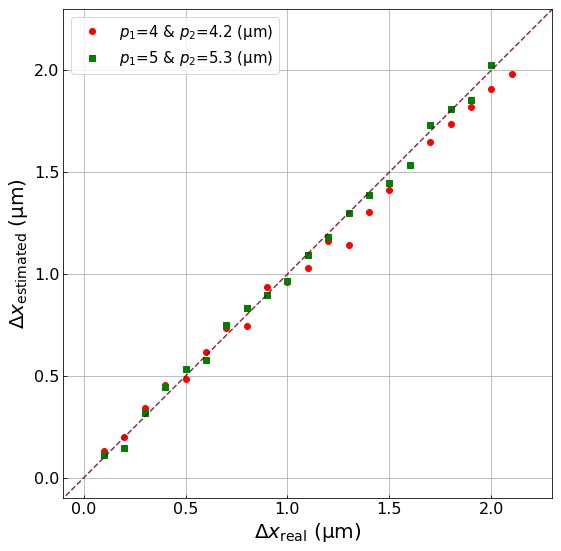

In [30]:
xmax=(len(offset)/10)+0.2
plt.figure(figsize=(16,9))
plt.xlabel("$Δx_\mathrm{real}$ (µm)",fontsize=20)
plt.gca().set_aspect('equal')
plt.ylabel("$Δx_\mathrm{estimated}$ (µm)",fontsize=20)
plt.xlim(-0.1,xmax)
plt.ylim(-0.1,xmax)

plt.plot(offset,re_dx,'ro',label='$p_\mathrm{1}$=4 & $p_\mathrm{2}$=4.2 (µm)')
plt.plot(SQ_offset,SQ_simulate,'gs',label='$p_\mathrm{1}$=5 & $p_\mathrm{2}$=5.3 (µm)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot([-10,10],[-10,10],'--',color='#660022',alpha=0.8)
plt.legend(loc='upper left',fontsize=15)
plt.grid(True)
# hist.xaxis.set_tick_params(direction='in')
plt.tick_params('both',direction='in')


line_pccs = np.corrcoef((offset, re_dx))
print(line_pccs)

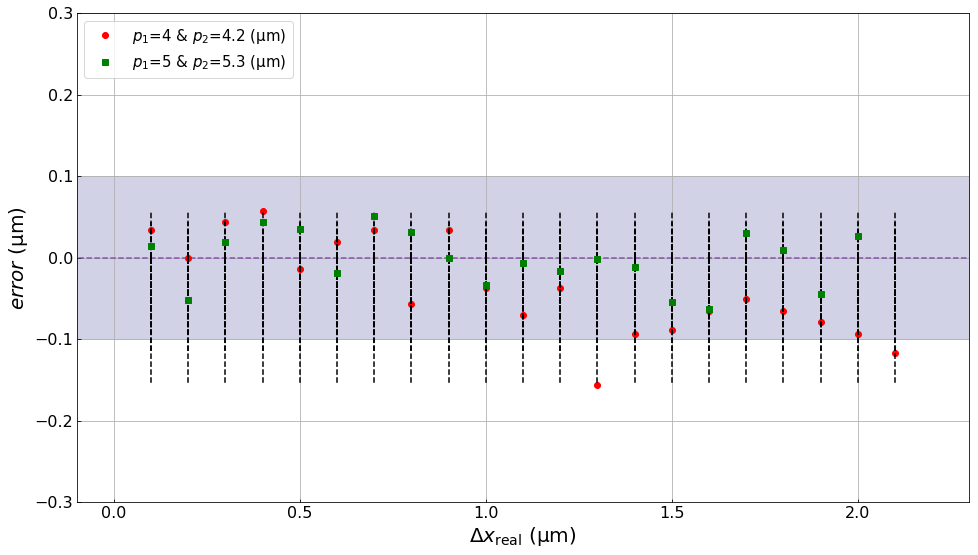

In [45]:
plt.figure(figsize=(16,9))
plt.ylim(-0.3,0.3)
plt.xlim(-0.1,xmax)
plt.fill_between([-10,10],[0.1,0.1],[-0.1,-0.1],color='#222288',alpha=0.2)
plt.plot([-10,10],[0,0],'--',color='#7733AA',alpha=0.8)
plt.xlabel("$Δx_\mathrm{real}$ (µm)",fontsize=20)
plt.ylabel("$error$ (µm)",fontsize=20)
plt.plot(offset,error,'ro',label='$p_\mathrm{1}$=4 & $p_\mathrm{2}$=4.2 (µm)')
# for k in offset:
#     for e in error:
#         plt.plot([k,k],[0,e],'k--')
    
plt.plot(SQ_offset,SQ_error,'gs',label='$p_\mathrm{1}$=5 & $p_\mathrm{2}$=5.3 (µm)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left',fontsize=15)
plt.grid(True)
plt.tick_params('both',direction='in')
# hist.xaxis.set_tick_params(direction='in')



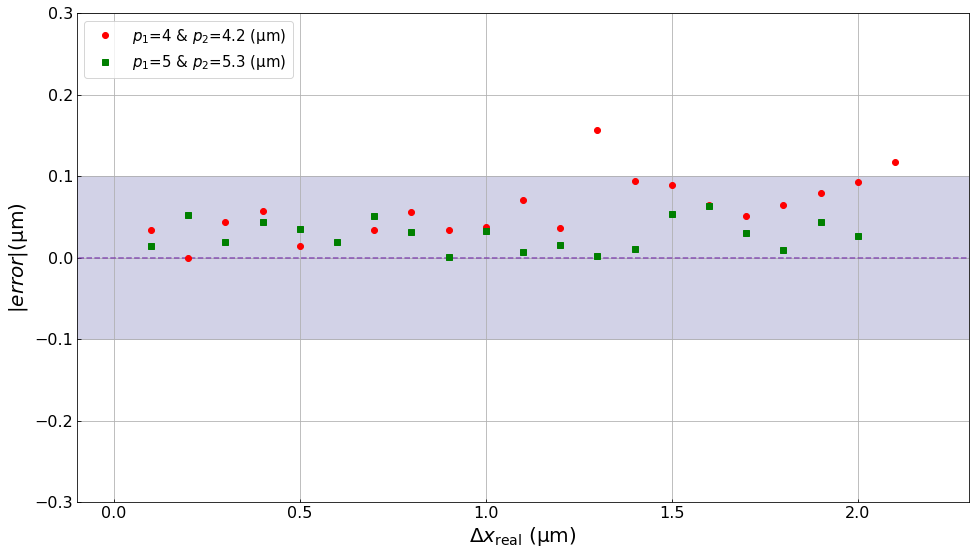

In [37]:
plt.figure(figsize=(16,9))
plt.ylim(-0.3,0.3)
plt.xlim(-0.1,xmax)
plt.fill_between([-10,10],[0.1,0.1],[-0.1,-0.1],color='#222288',alpha=0.2)
plt.plot([-10,10],[0,0],'--',color='#7733AA',alpha=0.8)
plt.xlabel("$Δx_\mathrm{real}$ (µm)",fontsize=20)
plt.ylabel("$|error|$(µm)",fontsize=20)

plt.plot(offset,Abs_error,'ro',label='$p_\mathrm{1}$=4 & $p_\mathrm{2}$=4.2 (µm)')
plt.plot(SQ_offset,SQ_error_abs,'gs',label='$p_\mathrm{1}$=5 & $p_\mathrm{2}$=5.3 (µm)')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left',fontsize=15)
plt.grid(True)

# hist.xaxis.set_tick_params(direction='in')
plt.tick_params('both',direction='in')

In [135]:
SQ_simulate=np.array([0.1138,0.148,0.3188,0.444,0.535,\
                     0.5807,0.7517,0.8312,0.8995,0.967,\
                     1.093,1.184,1.298,1.389,1.446,\
                      1.537,1.73,1.81,1.856,2.026])
M= 34.304
pix=7.8125
lens=10
print(SQ_simulate)
SQ_X=SQ_simulate*M*lens/pix
print(SQ_X)
 

[0.1138 0.148  0.3188 0.444  0.535  0.5807 0.7517 0.8312 0.8995 0.967
 1.093  1.184  1.298  1.389  1.446  1.537  1.73   1.81   1.856  2.026 ]
[ 4.99685786  6.49854976 13.99822746 19.49564928 23.4913792  25.49802598
 33.0064855  36.49726054 39.49625344 42.46011904 47.99266816 51.98839808
 56.99403776 60.98976768 63.49258752 67.48831744 75.9627776  79.4755072
 81.49532672 88.95987712]


In [136]:
LINE=np.arange(0.1,2.1,0.1)
LINE_simulate=np.array([7,10.5,18,24,25.5,\
                     32.5,38.5,39,49,50.5,\
                     54,61,60,68.5,74,\
                      80.5,86.5,91,95.5,100])
M= 40.976
pix=7.8125
lens=10
LINE_x=LINE_simulate*pix/M/lens
print(LINE_x)
LINE_error=LINE_x-LINE
print(LINE_error)
print(np.sum(abs(LINE_error))/len(LINE_error))

[0.13346227 0.20019341 0.3431887  0.45758493 0.48618399 0.61964626
 0.73404249 0.74357551 0.93423589 0.96283495 1.02956609 1.16302836
 1.14396232 1.30602365 1.41088686 1.53481611 1.64921234 1.73500952
 1.82080669 1.90660387]
[ 0.03346227  0.00019341  0.0431887   0.05758493 -0.01381601  0.01964626
  0.03404249 -0.05642449  0.03423589 -0.03716505 -0.07043391 -0.03697164
 -0.15603768 -0.09397635 -0.08911314 -0.06518389 -0.05078766 -0.06499048
 -0.07919331 -0.09339613]
0.056492184449433894
